# Fall Problem Session 4

## Building a Final Vehicle Sales Model

This problem session will be our last time working with a non-time series regression task.

These problems will touch on material from all of the lecture notebooks in the `Regression` folder.

Your overall goal for the notebook is to build the best regression model you can to predict the final selling price of a vehicle using the data in the `car_sales.csv` data.

In [1]:
## We first load in packages we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

#### 1. Load and process the data

##### a.

First load the `car_sales.csv` data. Then drop the missing values.

In [2]:
cars = pd.read_csv('../Data/car_sales.csv')

In [3]:
cars.dropna(inplace=True)

##### b.

Run the following code to clean and prepare the data.

<i>Note: there is nothing new here, all of this code was covered in `Fall Problem Session 2` and `Fall Problem Session 3`</i>.

In [4]:
def clean_column(text):
    return float(text.split()[0])

In [5]:
## Cleaning the mileage, engine and max_power columns
cars['mileage'] = cars['mileage'].apply(clean_column)
cars['engine'] = cars['engine'].apply(clean_column)
cars['max_power'] = cars['max_power'].apply(clean_column)

## creating the age column
cars['age'] = 2020 - cars['year']

## performing the log transform on selling_price and km_driven
cars['log_sell'] = np.log10(cars['selling_price'])
cars['log_km'] = np.log10(cars['km_driven'])

## making one-hot encoded variables for transmission, dealer and owner
cars['automatic'] = 1
cars.loc[cars.transmission=='Manual', 'automatic'] = 0

cars[['first_owner', 'second_owner', 'third_owner']] = pd.get_dummies(cars['owner'])[['First Owner', 
                                                                                      'Second Owner',
                                                                                      'Third Owner']]

cars['dealer'] = 1
cars.loc[cars.seller_type == 'Individual', 'dealer'] = 0

##### c. 

Here is a refresher on the columns of this data set.

<u>Outcome Variable</u>
- `selling_price` or `log_sell` (you will use `log_sell` in your models)

<u>Continuous Features</u>
- `km_driven` and thus `log_km`
- `mileage`
- `engine`
- `max_power`
- `seats`
- `age`

<u>Categorical Features</u>
- `fuel`
- `seller_type`
- `transmission`
- `owner`

<u>One-hot Encoded Variables</u>
- `automatic`: `1` if `transmission == "Automatic"`, `0` otherwise
- `dealer`: `1` if `seller_type != "Individual"`, `0` otherwise
- `first_owner`: `1` if `owner == "First Owner"`, `0` otherwise
- `second_owner`: `1` if `owner == "Second Owner"`, `0` otherwise
- `third_owner`: `1` if `owner == "Third Owner"`, `0` otherwise


You will ignore `torque` because it would require more cleaning than we will spend time on in these problem sessions.

#### d. 

Make a train test split, set $20\%$ aside for the test set.

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
cars_train,cars_test = train_test_split(cars,
                                         shuffle=True,
                                         random_state=100,
                                         test_size=0.2)

#### 2. Even more EDA

In the past two notebooks you have looked at potential relationships between `log_sell` and:
- `mileage`
- `log_km`
- `age`
- `fuel`
- `seller_type` or `dealer`
- `transmission` or `automatic` and
- `onwer` or `first_owner`, `second_owner` and `third_owner`.

This leaves three unexplored variables:
- `engine`
- `max_power`
- `seats`

##### a.

Make some plots and calculate relevant statistics to examine if these three variables are worth including in potential models.

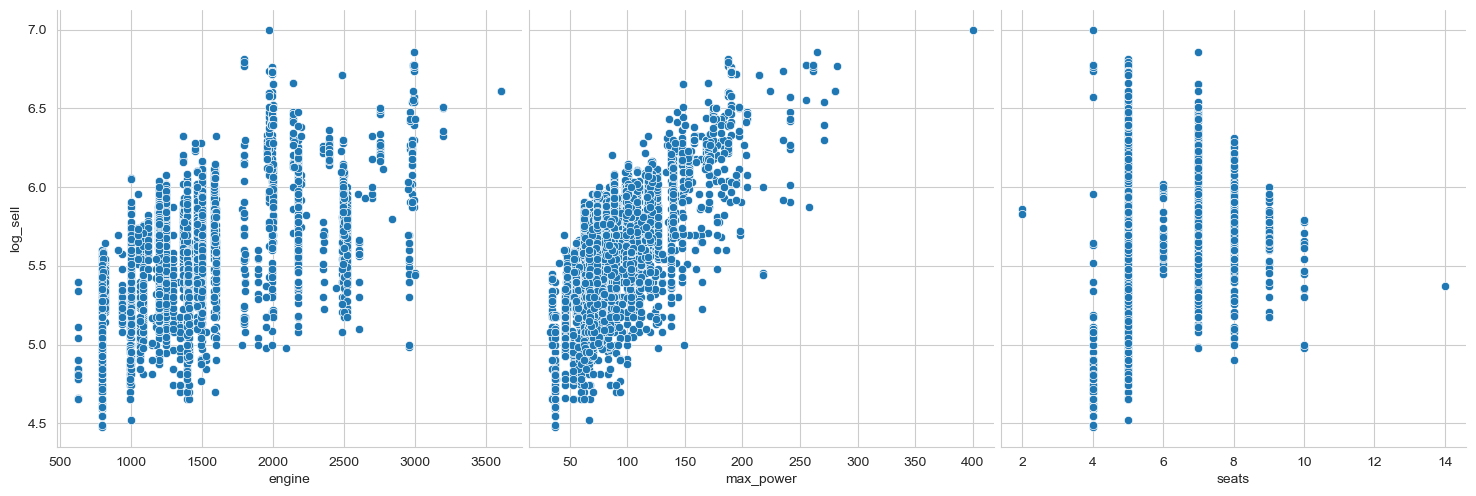

In [8]:
sns.pairplot(data=cars_train,
             x_vars = ['engine','max_power','seats'],
             y_vars = ['log_sell'],
             height=5)

plt.show()

In [9]:
cars_train[['engine','max_power','seats','log_sell']].corr()

,engine,max_power,seats,log_sell
engine,1.000000,0.706106,0.611284,0.515070
max_power,0.706106,1.000000,0.198145,0.730910
seats,0.611284,0.198145,1.000000,0.190036
log_sell,0.515070,0.730910,0.190036,1.000000


##### b.

Make a list of continuous variables you plan on considering for your model.

##### Write your answer here

engine, age, max_power

##### c.

Refer back to `Fall Problem Session 3`, make a list of categorical variables you plan on considering for your model.

##### Write your answer here

Automatic, Dealer

In [26]:
cars_train[['automatic','log_km','dealer','first_owner', 'second_owner', 'third_owner','age','log_sell']].corr()

,automatic,log_km,dealer,first_owner,second_owner,third_owner,age,log_sell
automatic,1.000000,-0.317104,0.377818,0.158200,-0.117416,-0.073829,-0.245646,0.501905
log_km,-0.317104,1.000000,-0.266805,-0.374139,0.274478,0.174914,0.543564,-0.367896
dealer,0.377818,-0.266805,1.000000,0.230717,-0.167214,-0.111481,-0.243486,0.364499
first_owner,0.158200,-0.374139,0.230717,1.000000,-0.817315,-0.363438,-0.497206,0.383223
second_owner,-0.117416,0.274478,-0.167214,-0.817315,1.000000,-0.152252,0.327365,-0.255503
third_owner,-0.073829,0.174914,-0.111481,-0.363438,-0.152252,1.000000,0.262091,-0.201612
age,-0.245646,0.543564,-0.243486,-0.497206,0.327365,0.262091,1.000000,-0.703020
log_sell,0.501905,-0.367896,0.364499,0.383223,-0.255503,-0.201612,-0.703020,1.000000


##### d.

A nice feature of many of `seaborn`'s plotting functions is the ability to change the `color` or `hue` of the plotted objects based on the values of a categorical variable.

Doing this with `lmplot`, <a href="https://seaborn.pydata.org/generated/seaborn.lmplot.html">https://seaborn.pydata.org/generated/seaborn.lmplot.html</a>, could be helpful when deciding if you want to add an interaction term.

Below is an example of how to implement the `hue` argument to investigate if we might want an interaction term between `age` and `transmission` in our model.

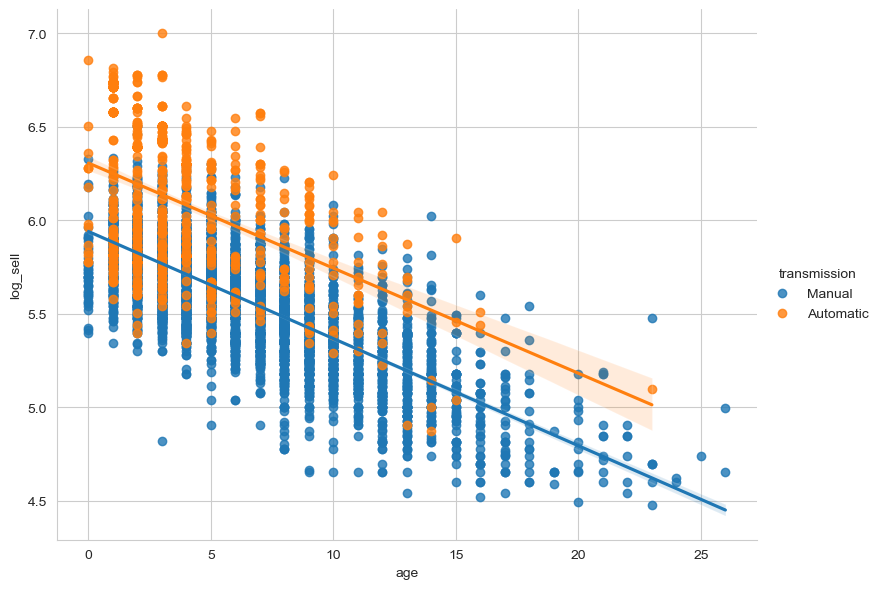

In [13]:
sns.lmplot(data=cars_train,
              x='age',
              y='log_sell',
              hue='transmission',
              height=6,
              aspect=1.3)

plt.show()

These two lines look roughly parallel indicating that there may not be an interaction between `age` and `transmission`.

Spend some time investigating such plots to decide whether any interaction terms are worth adding.

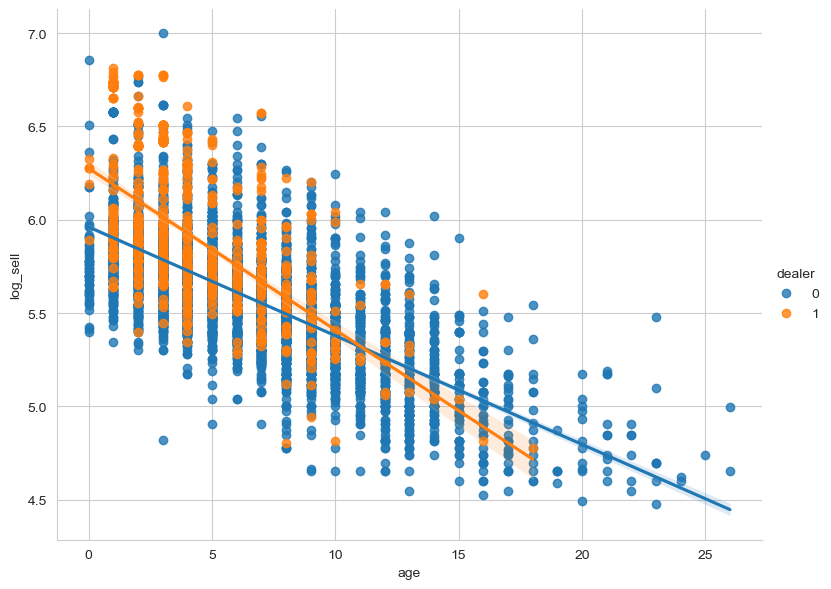

In [14]:
sns.lmplot(data=cars_train,
              x='age',
              y='log_sell',
              hue='dealer',
              height=6,
              aspect=1.3)

plt.show()

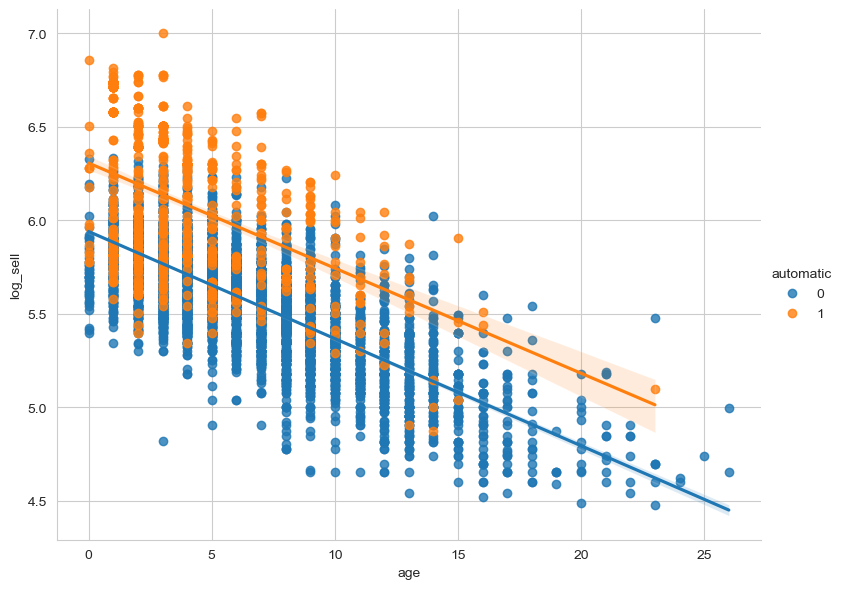

In [15]:
sns.lmplot(data=cars_train,
              x='age',
              y='log_sell',
              hue='automatic',
              height=6,
              aspect=1.3)

plt.show()

age-dealer
engine-max_power
engine-dealer

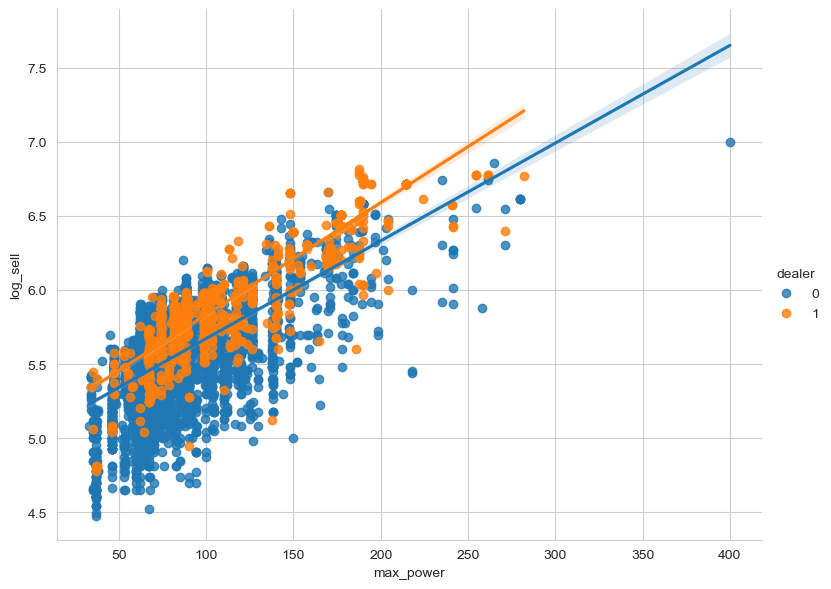

In [16]:
sns.lmplot(data=cars_train,
              x='max_power',
              y='log_sell',
              hue='dealer',
              height=6,
              aspect=1.3)

plt.show()

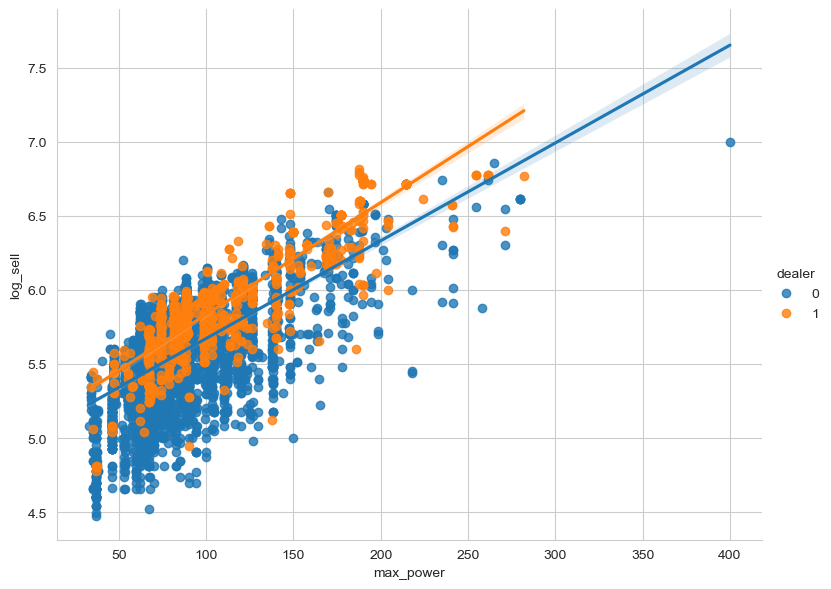

In [17]:
sns.lmplot(data=cars_train,
              x='max_power',
              y='log_sell',
              hue='dealer',
              height=6,
              aspect=1.3)

plt.show()

##### e.

Make a list of variables that you think <i>might</i> be good for a model predicting `log_sell` including any interactions we may not have made as columns yet. We will use this in the next portion of the notebook.

In [ ]:
[['engine','age','max_power','dealer','automatic']

##### Write your answer here



#### 3. Model comparisons

In this question we will work through a few different model selection procedures.

##### a. 

First you will try to implement <i>best subsets selection</i>. Remember that this is when you build all possible models from a given set of features and see which one has the lowest possible cross-validation MSE. Use the function `powerset` below to get a list of all possible models you will consider. 

<i>Note: You will need to make some alterations to the list returned by `powerset` if you chose to consider a categorical feature with more than two categories. For example, you couldn't have a model with just `first_owner` and `second_owner` but not `third_owner` you always have to have all three when building a model to include `owner`.</i>

In [ ]:
# This function was modified from stackexchange user hughdbrown 
# at this link, 
# https://stackoverflow.com/questions/1482308/how-to-get-all-subsets-of-a-set-powerset

# This returns the power set of a set minus the empty set
def powerset(s):
    power_set = []
    x = len(s)
    for i in range(1 << x):
        power_set.append([s[j] for j in range(x) if (i & (1 << j))])
        
    return power_set[1:]

In [ ]:
## An example of what power_set returns
powerset(['mileage', 'log_km'])

In [ ]:
## Make a list of the features you want to consider
potential_features = []

## create your list of models you will consider here using powerset
## all_models should be a list of lists of features
## for example you may have the list ['age'] in all_models to denote
## the model regressing log_sell on age
all_models = 



In [ ]:
## if you need to clean potential models here for categorical 
## variables do so here



##### b.

Fill in the code below to perform 5-fold cross-validation in order to compare all of the models you made above. Here you will make comparisons of the root mean squared error of the predictions of $10^{\log\left(\text{Selling Price}\right)}$.

In [ ]:
## import KFold
from sklearn.model_selection 

## import LinearRegression
from sklearn.linear_model

## import mean_squared_error
from sklearn.metrics import mean_squared_error

In [ ]:
## make a holder for all of your MSEs
mses = np.zeros()

## make the kfold object
kfold =

## you can use j as a counter for the split
j = 0

## complete the .split statement
for train_index, test_index in kfold:
    cars_tt = 
    cars_ho = 
    
    ## i is a counter for the model number
    i = 0
    for model in all_models:
        ## fit your model using log_sell as the y variable
        
        
        ## get your prediction on the holdout set
        ## the .predict statement should go after the "10," but before the ")"
        pred = np.power(10, )
        
        ## record the mses using selling_price as the true values
        mses[i,j]
        
        ## increase the count accordingly
        i = i + 1
    ## increase the count accordingly
    j = j + 1

In [ ]:
## the minimum root mse
np.min(np.mean(np.sqrt(mses), axis=1))

In [ ]:
## the model that attained that minimum
all_models[np.argmin(np.mean(np.sqrt(mses), axis=1))]

##### c.

Now attempt to use lasso regression for feature selection on the features:
- `mileage`
- `max_power`
- `age`
- `engine`
- `log_km`
- `seats`
- `dealer`
- `automatic`
- `first_owner`
- `second_owner`
- `third_owner`.

How do the results compare with what you found in <i>b.</i>?

<i>Hint: remember to scale your continuous features with `StandardScaler` first.</i>

In [ ]:
## import StandardScaler
from sklearn.preprocessing 

## import Lasso
from sklearn.linear_model 

In [ ]:
## This will hold your scaled data
## after the comma put the number of features you are considering
scaled_data = np.zeros((len(cars_train), ))

## make the scaler object here
scaler = 

## use .fit_transform to fit the scaler and then scale the relevant data
## make sure that you put in the correct number of columns after the second ":"
## in scaled_data[:,:], for example, if you had 5 continuous variables you were scaling
## you would put scaled_data[:,:5]
scaled_data[:,:6] = 

## copy over the unscaled one hot encoded columns accordingly

## dealer
scaled_data[:,] = 

## automatic
scaled_data[:,] = 

## first_owner
scaled_data[:,] = 

## second_owner
scaled_data[:,] = 

## third_owner
scaled_data[:,] = 

In [ ]:
## All of the alphas we will loop through for our lasso
alphas = [0.00001,0.0001,0.001,0.005,0.0075,0.01,0.015,0.05,0.1,1]

## this will hold the coefficients from each lasso
coefs = np.zeros((len(alphas), 11))

## the loop
## note if you are unsure of what enumerate does
## https://docs.python.org/3/library/functions.html#enumerate
for i,alpha in enumerate(alphas):
    ## make the lasso object
    lasso = Lasso()
    
    ## fit the lass object
    ## remember that scaled_data are now the features you will use
    lasso.fit()
    
    ## store the coefficients
    coefs[i, :] = lasso.coef_

## when you are done this will display the
## coefficients in a nice dataframe
## NOTE: you should check the column order to make sure
## they match what you put into scaled_data
pd.DataFrame(coefs, 
                index=["alpha = " + str(alpha) for alpha in alphas],
                columns=['mileage', 'max_power',
                          'age', 'engine', 
                          'log_km', 'seats',
                          'dealer', 'automatic',
                          'first_owner', 'second_owner',
                          'third_owner'])

##### Make any notes you would like here

If you would like you can compare the avg cross-validation RMSE for the model suggested by lasso here to the model from best subsets selection using the results that should still be stored in `mses`.

##### d.

While we have only covered linear regression model types up to this point there are other regression models. One <i>nonparametric</i> approach is to use <i>$k$-nearest neighbors regression</i>.

This model works by taking the average value of $y$ for $X$'s $k$ nearest neighbors in the training set, where nearest here means the observations in the training set that are closest to $X$ in terms of some distance measure (like Euclidean distance) and $k$ is chosen prior to fitting the model. This model can be fit using `sklearn`'s `KNeighborsRegressor`, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html">https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html</a>.

Using only continuous features from your best linear regression model fit a $k$-nearest neighbors regression model with $k=5, 10, 15, 20, 25$ and see which one performs best. Then compare this performance to your best linear regression model.

In [ ]:
## This import KNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
## Place the values of k you will loop through in a list
ks = []

knn_mses = np.zeros((len(ks), 5))

j = 0
for train_index, test_index in kfold.split(cars_train):
    cars_tt = cars_train.iloc[train_index]
    cars_ho = cars_train.iloc[test_index]
    
    for i,k in enumerate(ks):
        ## this creates the knn model with k neighbors
        knn = KNeighborsRegressor(k)
        
        ## this fits the knn model
        knn.fit(cars_tt[['max_power', 'age', 'engine', 'log_km', 'seats']],
                   cars_tt.log_sell)
        
        ## this gets the prediction for the knn model of selling_price
        pred = np.power(10, knn.predict(cars_ho[['max_power', 'age', 'engine', 'log_km', 'seats']]))
        
        ## record the mse for this model
        knn_mses[i,j] = 
    j = j + 1

In [ ]:
## What was the k value with the lowest avg. cv rmse?


In [ ]:
## What was that lowest avg cv rmse?


In [ ]:
## compare that to the best avg cv rmse from
## the linear regression models above


##### Write any notes you would like here

##### e.

Prior to choosing your final model, reflect on whether any othe features could have been considered when making this model. You may want to examine a few of the vehicle names while answering this question.

##### Write any code or notes you would like below

#### 4 Examining the test performance

##### a. 

From all of your investigations choose a final model.

##### Write here

##### b.

Fit the model you chose on the entire training set.

##### c. 

Calculate the root mean squared error for the prediction of $10^{\log\left(\text{Selling Price}\right)}$ on the training set and the test set.

<i>Note: if you did any additional cleaning or feature creation, like making interaction terms, you will need to do that to the test set if you have not already.</i>

#### 5. (Bonus) Coefficient of determination or $R^2$

In this bonus question you will learn about the <i>coefficient of determination, or $R^2$, as well as adjusted $R^2$. This should only be worked through if you still have time after completing all of the above work.

##### a.

While we have focused on the MSE or RMSE of a model another popular metric is the coefficient of determination, otherwise known as $R^2$. Before defining it is important to note the $R$ is <i>different</i> from $r$, the variable we use to denote the sample Pearson correlation, however in simple linear regression the two are related.

Recall that the sample variance for $y$ is given by:

$$
s_y^2 = \frac{\sum_{i=1}^n \left(y_i - \overline{y} \right)^2}{n-1},
$$

where $\overline{y}$ denotes the sample mean of $y$. The numerator of this fraction is often referred to as the total sum of squares:

$$
\text{SST} = \sum_{i=1}^n \left(y_i - \overline{y} \right)^2.
$$

It can be shown that:

$$
\text{SST} = \sum_{i=1}^n \left(\hat{y}_i - \overline{y} \right)^2 + \sum_{i=1}^n \left(y_i - \hat{y}_i \right)^2 = \text{SSR} + \text{SSE},
$$

where $\text{SSR}$ stands for regression sum of squares and $\text{SSE}$ stands for the residual sum of squares. <i>To help remember the abbreviations it is useful to remember that residuals are also called errors.</i>

<i>For a proof of this fact it can be helpful to write this out using linear algebra. A proof can also be found at this link <a href="https://webspace.maths.qmul.ac.uk/b.bogacka/SM_I_2013_LecturesWeek_8.pdf">https://webspace.maths.qmul.ac.uk/b.bogacka/SM_I_2013_LecturesWeek_8.pdf</a>.</i>

The coefficient of determination, or $R^2$ is defined as:

$$
R^2 = \frac{\text{SSR}}{\text{SST}},
$$

and can be interpretted as the proportion of the variance in the variable of interest accounted for by the model. Note that $R^2 \in [0,1]$  with $R^2=0$ indicating that your model accounts for none of the data's variance and $R^2=1$ meaning that your model accounts for all of the data's variance. Typically you look for the model with the <i>largest</i> $R^2$.

Regress `log_sell` on `age` alone using the training data and then calculate $R^2$, you can do this by hand or by using `sklearn`'s `r2_score` metric, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html">https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html</a>. Interpret this value.

In [ ]:
## if you want to use r2_score
from sklearn.metrics import r2_score

##### b.

Calculate the Pearson correlation between `log_sell` and `age` using the training set, then square it. What do you notice?

<i>Note: what you notice only holds true in the case of simple linear regression.</i>

#### c.

Now fit the linear regression model you settled on above using the training data. Calculate the $R^2$ and interpret it.

##### d.

One drawback of $R^2$ is that it is <i>non-decreasing</i> with the addition of new features. So by only considering $R^2$ during model selection you will be more likely to spuriously choose models with more features.

One way to account for this non-decreasing property is to use what is known as <i>adjusted $R^2$</i> instead, which institutes a penalty dependent on the number of features you use. Adjusted $R^2$ can be calculated using this formula:

$$
R^2_\text{adj} = 1 - (1 - R^2)\frac{n-1}{n-p},
$$

where $n$ is the total number of observations and $p$ is the number of features used in your model.

Compare the adjusted $R^2$ for the models you used in parts 5 <i>a.</i> and <i>c.</i>.

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2022.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)